# Estimating Black-Scholes option prices

# Table of Contents
- [Read and clean data](#Read-and-clean-data)
- [Analysis](#Analysis)
- [Conclusion](#Conclusion)

Imports and set magics:

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf
from scipy.stats import norm
import datetime as dt
import dataproject
dp = dataproject.DataProject()

In [12]:
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

c:\Users\rasmu\anaconda3\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


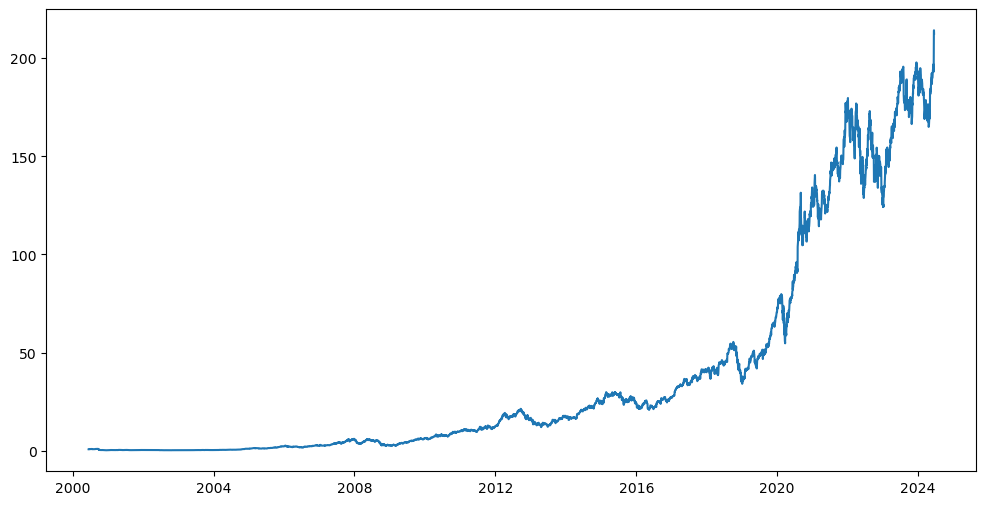

In [25]:
# Fetch the historical stock data for Apple
data = yf.Ticker('AAPL')
data = data.history(period="24y", interval="1d")
data = data['Close']

# Plotting the stock price
plt.figure(figsize=(12,6))
plt.plot(data)
plt.show()

In the plot can we see the adjusted close prices for Apple for 2000 till now. We wish to price the option from a Apple stock using Black-Scholes, and compare with the real prices. The last observed price on the stock is 171. Black-Scholes uses implied volatility, which we get from the VIX index.


c:\Users\rasmu\anaconda3\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


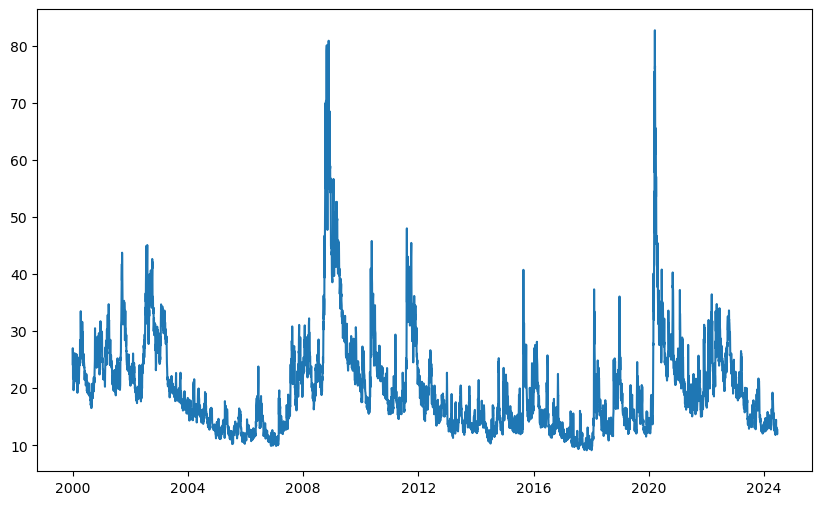

In [26]:
# Importing VIX index data
vix = dp.get_stock_data('^VIX', '2000-01-01')
vix = vix['Close'] # Keep only the closing price
vix = vix.dropna()  # Drop missing values

plt.figure(figsize=(10,6))
plt.plot(vix)

It is observed that the last observed VIX value is about 15.7, which we are gonna use for the Black-SCholes model.
Lastly we will import option data on Apple, and find the risk free-rate

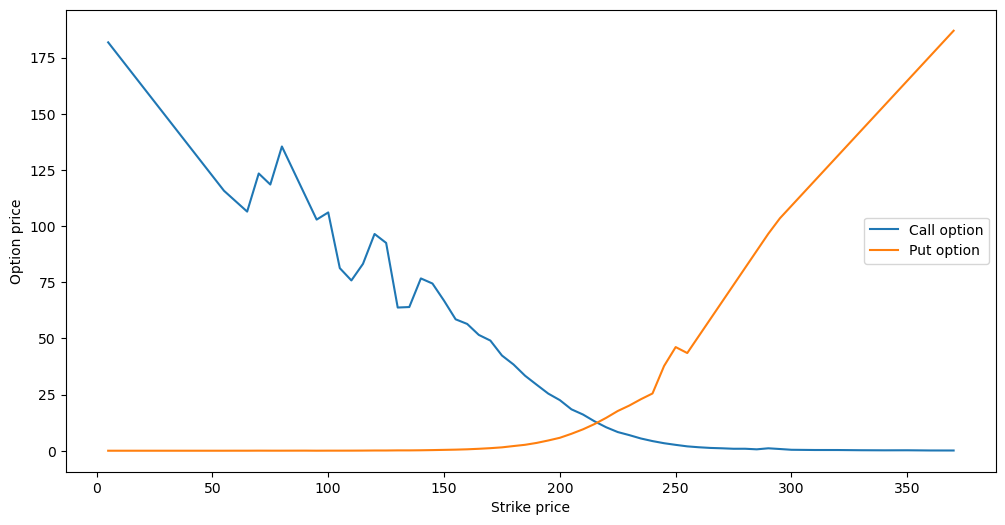

In [33]:
# Initialize the data object as a Ticker object for the specified stock
ticker_symbol = 'AAPL'  
data = yf.Ticker(ticker_symbol)


# Fetch the option chain for the specified date
option_data = data.option_chain('2024-11-15')
option_call = option_data.calls
option_put = option_data.puts

# Plotting the option chain
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(option_call['strike'], option_call['lastPrice'], label='Call option')
plt.plot(option_put['strike'], option_put['lastPrice'], label='Put option')
plt.xlabel('Strike price')
plt.ylabel('Option price')
plt.legend()
plt.show()

# Analysis

The formula for Black Scholes put and all option is:

### Call Option Formula:

$$
\text{Call} = S_0 N(d_1) - N(d_2) K e^{-rT}
$$

### Put Option Formula:

$$
\text{Put} = N(-d_2) K e^{-rT} - N(-d_1) S_0
$$

### Where:

- $$d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}$$

- $$d_2 = d_1 - \sigma\sqrt{T}$$

**Variables:**

- $S_0$: Initial stock price
- $N()$: Cumulative distribution function of the standard normal distribution
- $K$: Strike price of the option
- $e$: The base of the natural logarithm
- $r$: Risk-free interest rate
- $T$: Time to maturity of the option
- $\sigma$: implied volatility


We wish to analyse how the time to maturity effects the options pricing, hence we make T a list a try to plot. We set the strikeprice to 172.5 which is the most traded strike price


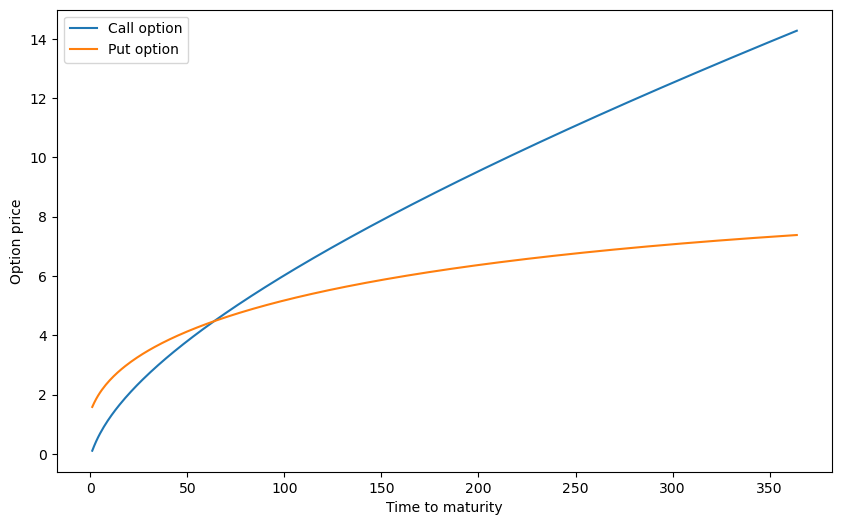

In [28]:
K = 172.5
S = 171
r = 0.05
T = range(1, 365)
sigma = 0.157
C = [dp.black_scholes(S, K, r, sigma, t/365, 'call') for t in T]
P = [dp.black_scholes(S, K, r, sigma, t/365, 'put') for t in T]

plt.figure(figsize=(10,6))
plt.plot(T, C, label='Call option')
plt.plot(T, P, label='Put option')
plt.xlabel('Time to maturity')
plt.ylabel('Option price')
plt.legend()
plt.show()

We see as the Time increase, both put and call options prices incrase. This could be because of their sercurity attriubutes. We can also the a test of how the implied volatility effects the pricing

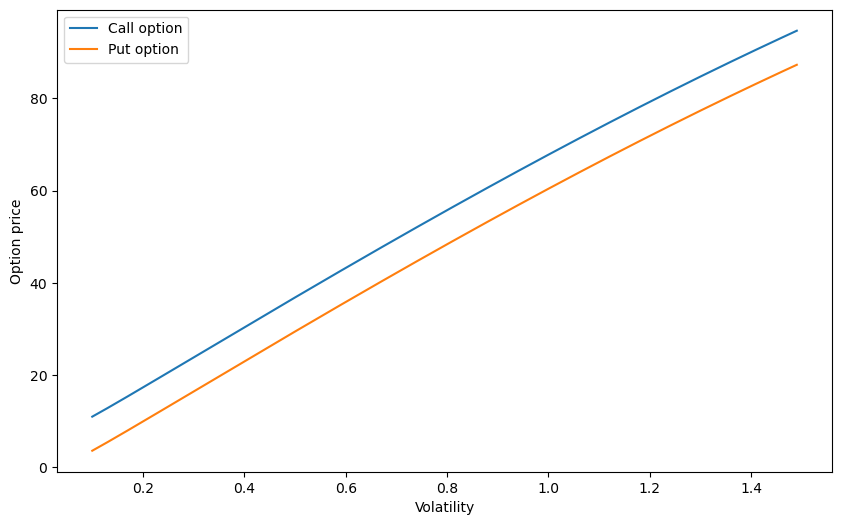

In [29]:
K = 172
S = 171
r = 0.05
T = 1  
sigma_range = np.arange(0.1, 1.5, 0.01)

C = [dp.black_scholes(S, K, r, sigma, T, 'call') for sigma in sigma_range]
P = [dp.black_scholes(S, K, r, sigma, T, 'put') for sigma in sigma_range]

plt.figure(figsize=(10,6))
plt.plot(sigma_range, C, label='Call option')
plt.plot(sigma_range, P, label='Put option')
plt.xlabel('Volatility')
plt.ylabel('Option price')
plt.legend()
plt.show()


We can now try to model the BS model to the real option prices

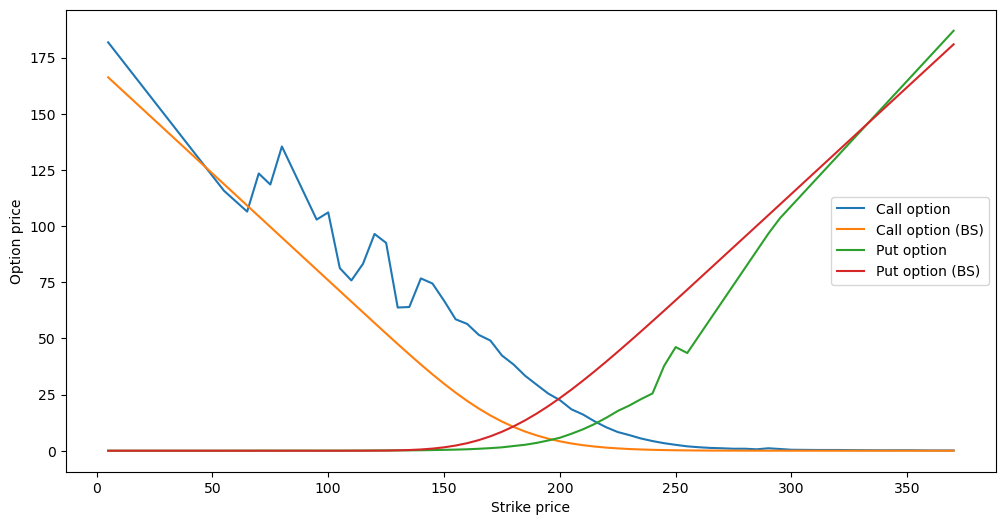

In [31]:
# Calculate the call and put option prices for all strike prices
option_data.calls['bs_price'] = [dp.black_scholes(S, K, r, sigma, T, 'call') for K in option_data.calls['strike']]
option_data.puts['bs_price'] = [dp.black_scholes(S, K, r, sigma, T, 'put') for K in option_data.puts['strike']]

# Plot the option prices
plt.figure(figsize=(12,6))
plt.plot(option_data.calls['strike'], option_data.calls['lastPrice'], label='Call option')
plt.plot(option_data.calls['strike'], option_data.calls['bs_price'], label='Call option (BS)')
plt.plot(option_data.puts['strike'], option_data.puts['lastPrice'], label='Put option')
plt.plot(option_data.puts['strike'], option_data.puts['bs_price'], label='Put option (BS)')
plt.xlabel('Strike price')
plt.ylabel('Option price')
plt.legend()
plt.show()


We see that the Black-Scholes follows the option price behavior, but does not hit it spot on.
Note that the conclussion might change, since the option chain is changing in last traded price.

# Conclusion

The Root Mean Square Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data. Formally, it is defined as the square root of the average squared differences between the predicted and actual values:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$


RMSE for call options: 14.382891595789125
RMSE for put options: 7.64894808767885


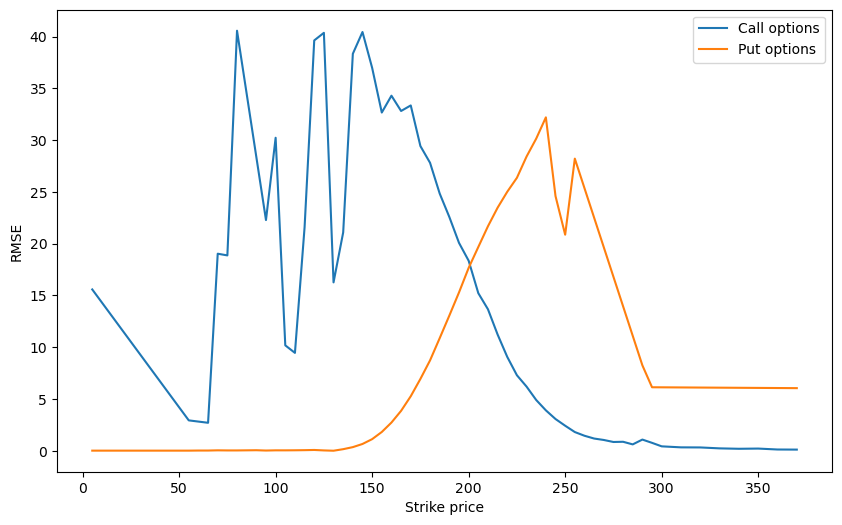

In [32]:
# Calculate the RMSE for each calculated price
RMSE_call = np.sqrt((option_data.calls['lastPrice'] - option_data.calls['bs_price'])**2)
RMSE_put = np.sqrt((option_data.puts['lastPrice'] - option_data.puts['bs_price'])**2)

# Print the overall RMSE
print(f'RMSE for call options: {np.mean(RMSE_call)}')
print(f'RMSE for put options: {np.mean(RMSE_put)}')

# Plot the RMSE for each calculated price
plt.figure(figsize=(10,6))
plt.plot(option_data.calls['strike'], RMSE_call, label='Call options')
plt.plot(option_data.puts['strike'], RMSE_put, label='Put options')
plt.xlabel('Strike price')
plt.ylabel('RMSE')
plt.legend()
plt.show()

We can see that the put-options produce the smallest errors, hence Black-Scholes is most accurate at pricing them. It should be noted, that there is one put option that pricing are way off, hence is pulling up the average.
Again conclussion can change because of changing last traded prices in options and the Apple stock.